## Загрузка библиотек


In [1]:
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor,Pool,metrics,cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,mean_squared_error,r2_score,mean_absolute_percentage_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.ticker as ticker  

## Задаем стили для графиков

In [2]:
params = {'figure.figsize' : (12,8),
         'font.size' : 12,
         'axes.titlesize' : 20,
         'axes.linewidth' : 2}

plt.rcParams.update(params)

bbox = {'boxstyle' : 'round',
        'pad' : 0.5,
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1,
        'alpha' : 1}

color = ['#E36149', '#49AF72']

plt.style.use('fivethirtyeight')

## Загрузка данных

In [3]:
train_events = pd.read_csv('train_events.csv')
train_targets = pd.read_csv('train_targets.csv')

# Объединение таблицы train_events с train_targets по столбцу viewer_uid
df = pd.merge(train_events, train_targets, on='viewer_uid', how='left')

In [36]:
train_events.ua_client_name.unique()

array(['Yandex Browser', 'Rutube', 'Chrome', 'Microsoft Edge', 'Firefox',
       'Safari', 'vivo Browser', 'Chrome Mobile', 'Opera',
       'Firefox Mobile', 'Chrome Mobile iOS', 'Mobile Safari',
       'Samsung Browser', 'Atom', 'Chrome Webview', 'Android Browser',
       'Opera Mobile', 'Google Search App', 'Chromium',
       'Yandex Browser Lite', 'Opera Mini', 'Huawei Browser Mobile',
       'MIUI Browser', 'SberBrowser', 'Opera GX', 'Opera Touch',
       'Nokia Browser', 'Mobile Silk', 'Internet Explorer',
       'AdBlock Browser', 'Iron', 'IE Mobile', 'Firefox Focus',
       'DuckDuckGo Privacy Browser', 'RDDocuments',
       'Avast Secure Browser', 'Avast', 'Aloha Browser', 'Soul Browser',
       'CoolBrowser', 'QtWebEngine', 'AVG Secure Browser',
       'BlackBerry Browser', 'UC Browser', 'Firefox Mobile iOS',
       'Microsoft Bing Search', 'Vivaldi', 'HeyTapBrowser', 'Facebook',
       'Stargon', 'Chromium GOST', 'WeChat', 'Ecosia',
       'Smart Lenovo Browser', 'Whale Brows

In [4]:
# Отображение датасета
df.head()

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,age,sex,age_class
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,20,female,0
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,40,female,2
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333,23,male,1
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,41,male,3
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,38,female,2


In [5]:
# Смторим размерсноть датасета
df.shape

(1759616, 12)

In [6]:
# Смотрим типы данных столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759616 entries, 0 to 1759615
Data columns (total 12 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   event_timestamp  object
 1   region           object
 2   ua_device_type   object
 3   ua_client_type   object
 4   ua_os            object
 5   ua_client_name   object
 6   total_watchtime  int64 
 7   rutube_video_id  object
 8   viewer_uid       int64 
 9   age              int64 
 10  sex              object
 11  age_class        int64 
dtypes: int64(4), object(8)
memory usage: 161.1+ MB


In [7]:
# Cмотрим пропуски
df.isna().sum()

event_timestamp         0
region                  0
ua_device_type          0
ua_client_type          0
ua_os              117671
ua_client_name          0
total_watchtime         0
rutube_video_id         0
viewer_uid              0
age                     0
sex                     0
age_class               0
dtype: int64

## Отображаем дисбаланс целевых классов

C:\Users\Pasha\AppData\Local\Temp\ipykernel_2984\780858854.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p1 = sns.countplot(data=df,


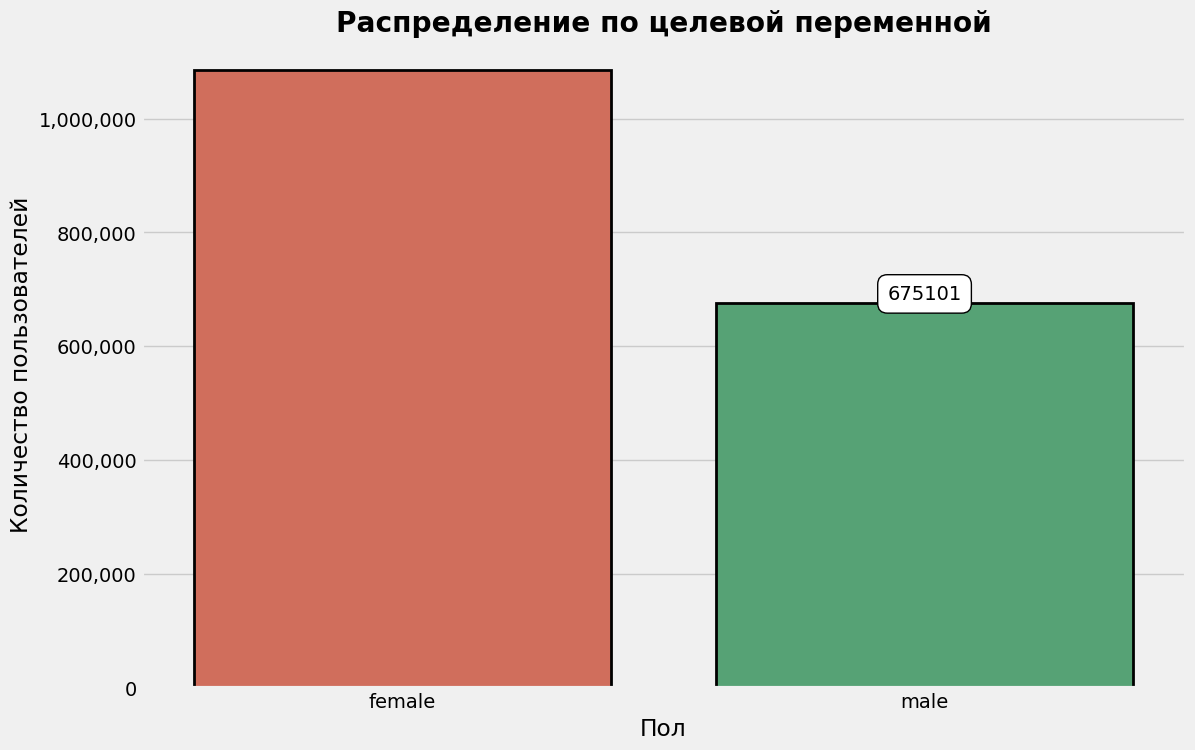

In [8]:
# Создаем график
p1 = sns.countplot(data=df,
                   x='sex',
                   linewidth=2,
                   edgecolor='black',
                   palette=color)

# Настраиваем заголовки осей
plt.title('Распределение по целевой переменной', fontweight='bold')
plt.xlabel('Пол')
plt.ylabel('Количество пользователей')

p1.bar_label(p1.containers[1], bbox = bbox)
# Форматируем ось y, чтобы убрать научную нотацию
p1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Показываем график
plt.show()


C:\Users\Pasha\AppData\Local\Temp\ipykernel_2984\1775380222.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p1 = sns.countplot(data=df,
C:\Users\Pasha\AppData\Local\Temp\ipykernel_2984\1775380222.py:2: UserWarning: 
The palette list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  p1 = sns.countplot(data=df,


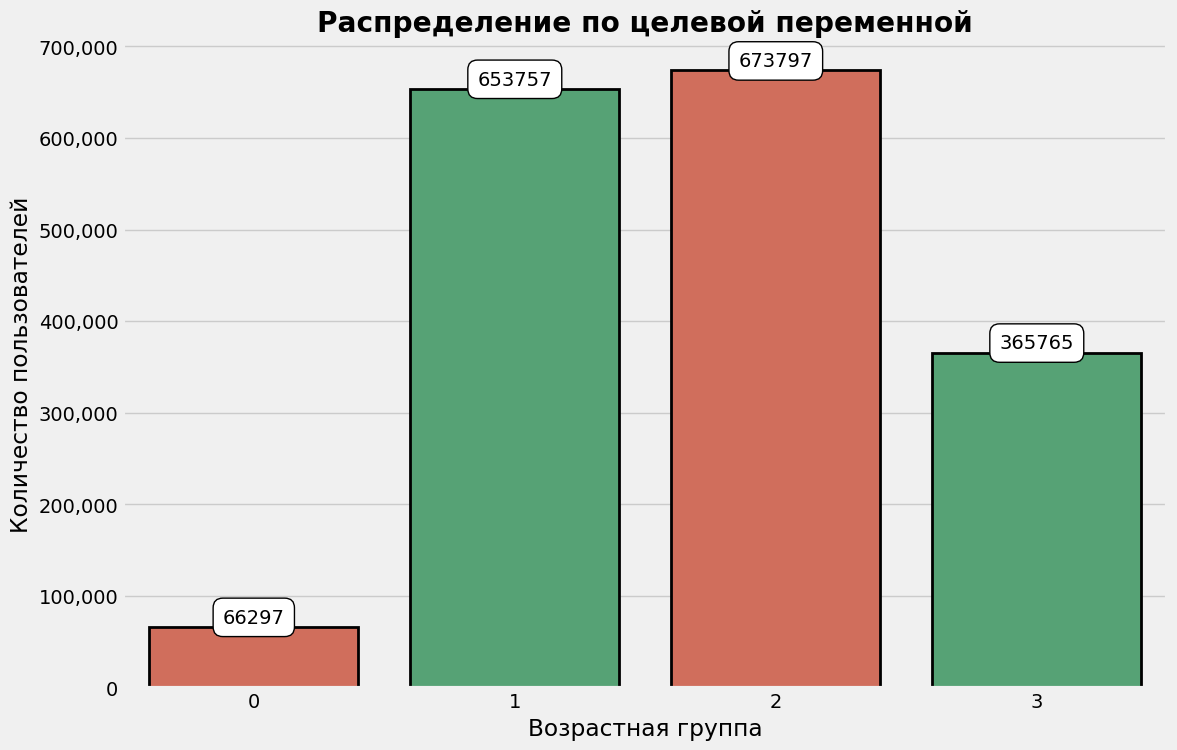

In [9]:
# Создаем график
p1 = sns.countplot(data=df,
                   x='age_class',
                   linewidth=2,
                   edgecolor='black',
                   palette=color)

# Настраиваем заголовки осей
plt.title('Распределение по целевой переменной', fontweight='bold')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество пользователей')

p1.bar_label(p1.containers[0], bbox = bbox)
p1.bar_label(p1.containers[1], bbox = bbox)
p1.bar_label(p1.containers[2], bbox = bbox)
p1.bar_label(p1.containers[3], bbox = bbox)
# Форматируем ось y, чтобы убрать научную нотацию
p1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Показываем график
plt.show()


## Признаки давшие профит

In [10]:
# Создание нового столбца, который содержит количество просмотров для каждого пользователя
df['view_count'] = df.groupby('viewer_uid')['viewer_uid'].transform('count')

#Создать новый признак, который будет представлять собой суммарное время просмотра видео для каждого пользователя.
df['total_watchtime_per_user'] = df.groupby('viewer_uid')['total_watchtime'].transform('sum')

# Просмотр результата
print(df[['viewer_uid', 'view_count']].drop_duplicates().head())

   viewer_uid  view_count
0    10067243          43
1    10245341          67
2    10894333           4
3    10029092          10
4    10452976          33


## Фунцкия для отображения выбросов в данных через boxplot

In [11]:
def plot_boxplots(dataframe):
    num_columns = dataframe.select_dtypes(include=['number']).columns 
    num_plots = len(num_columns)
    rows = (num_plots + 1) // 2  # Определение количества строк в сетке подграфиков

    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(40, 60))
    

    for i, column in enumerate(num_columns):
        row = i // 2
        col = i % 2
        ax = axes[row, col]
        sns.boxplot(x=dataframe[column], ax=ax)
        ax.set_title(f"Boxplot of {column}",fontsize=30,fontweight='bold')
        ax.set_xlabel(column)
        ax.tick_params(labelsize=20)
        

    plt.tight_layout()
    plt.show()

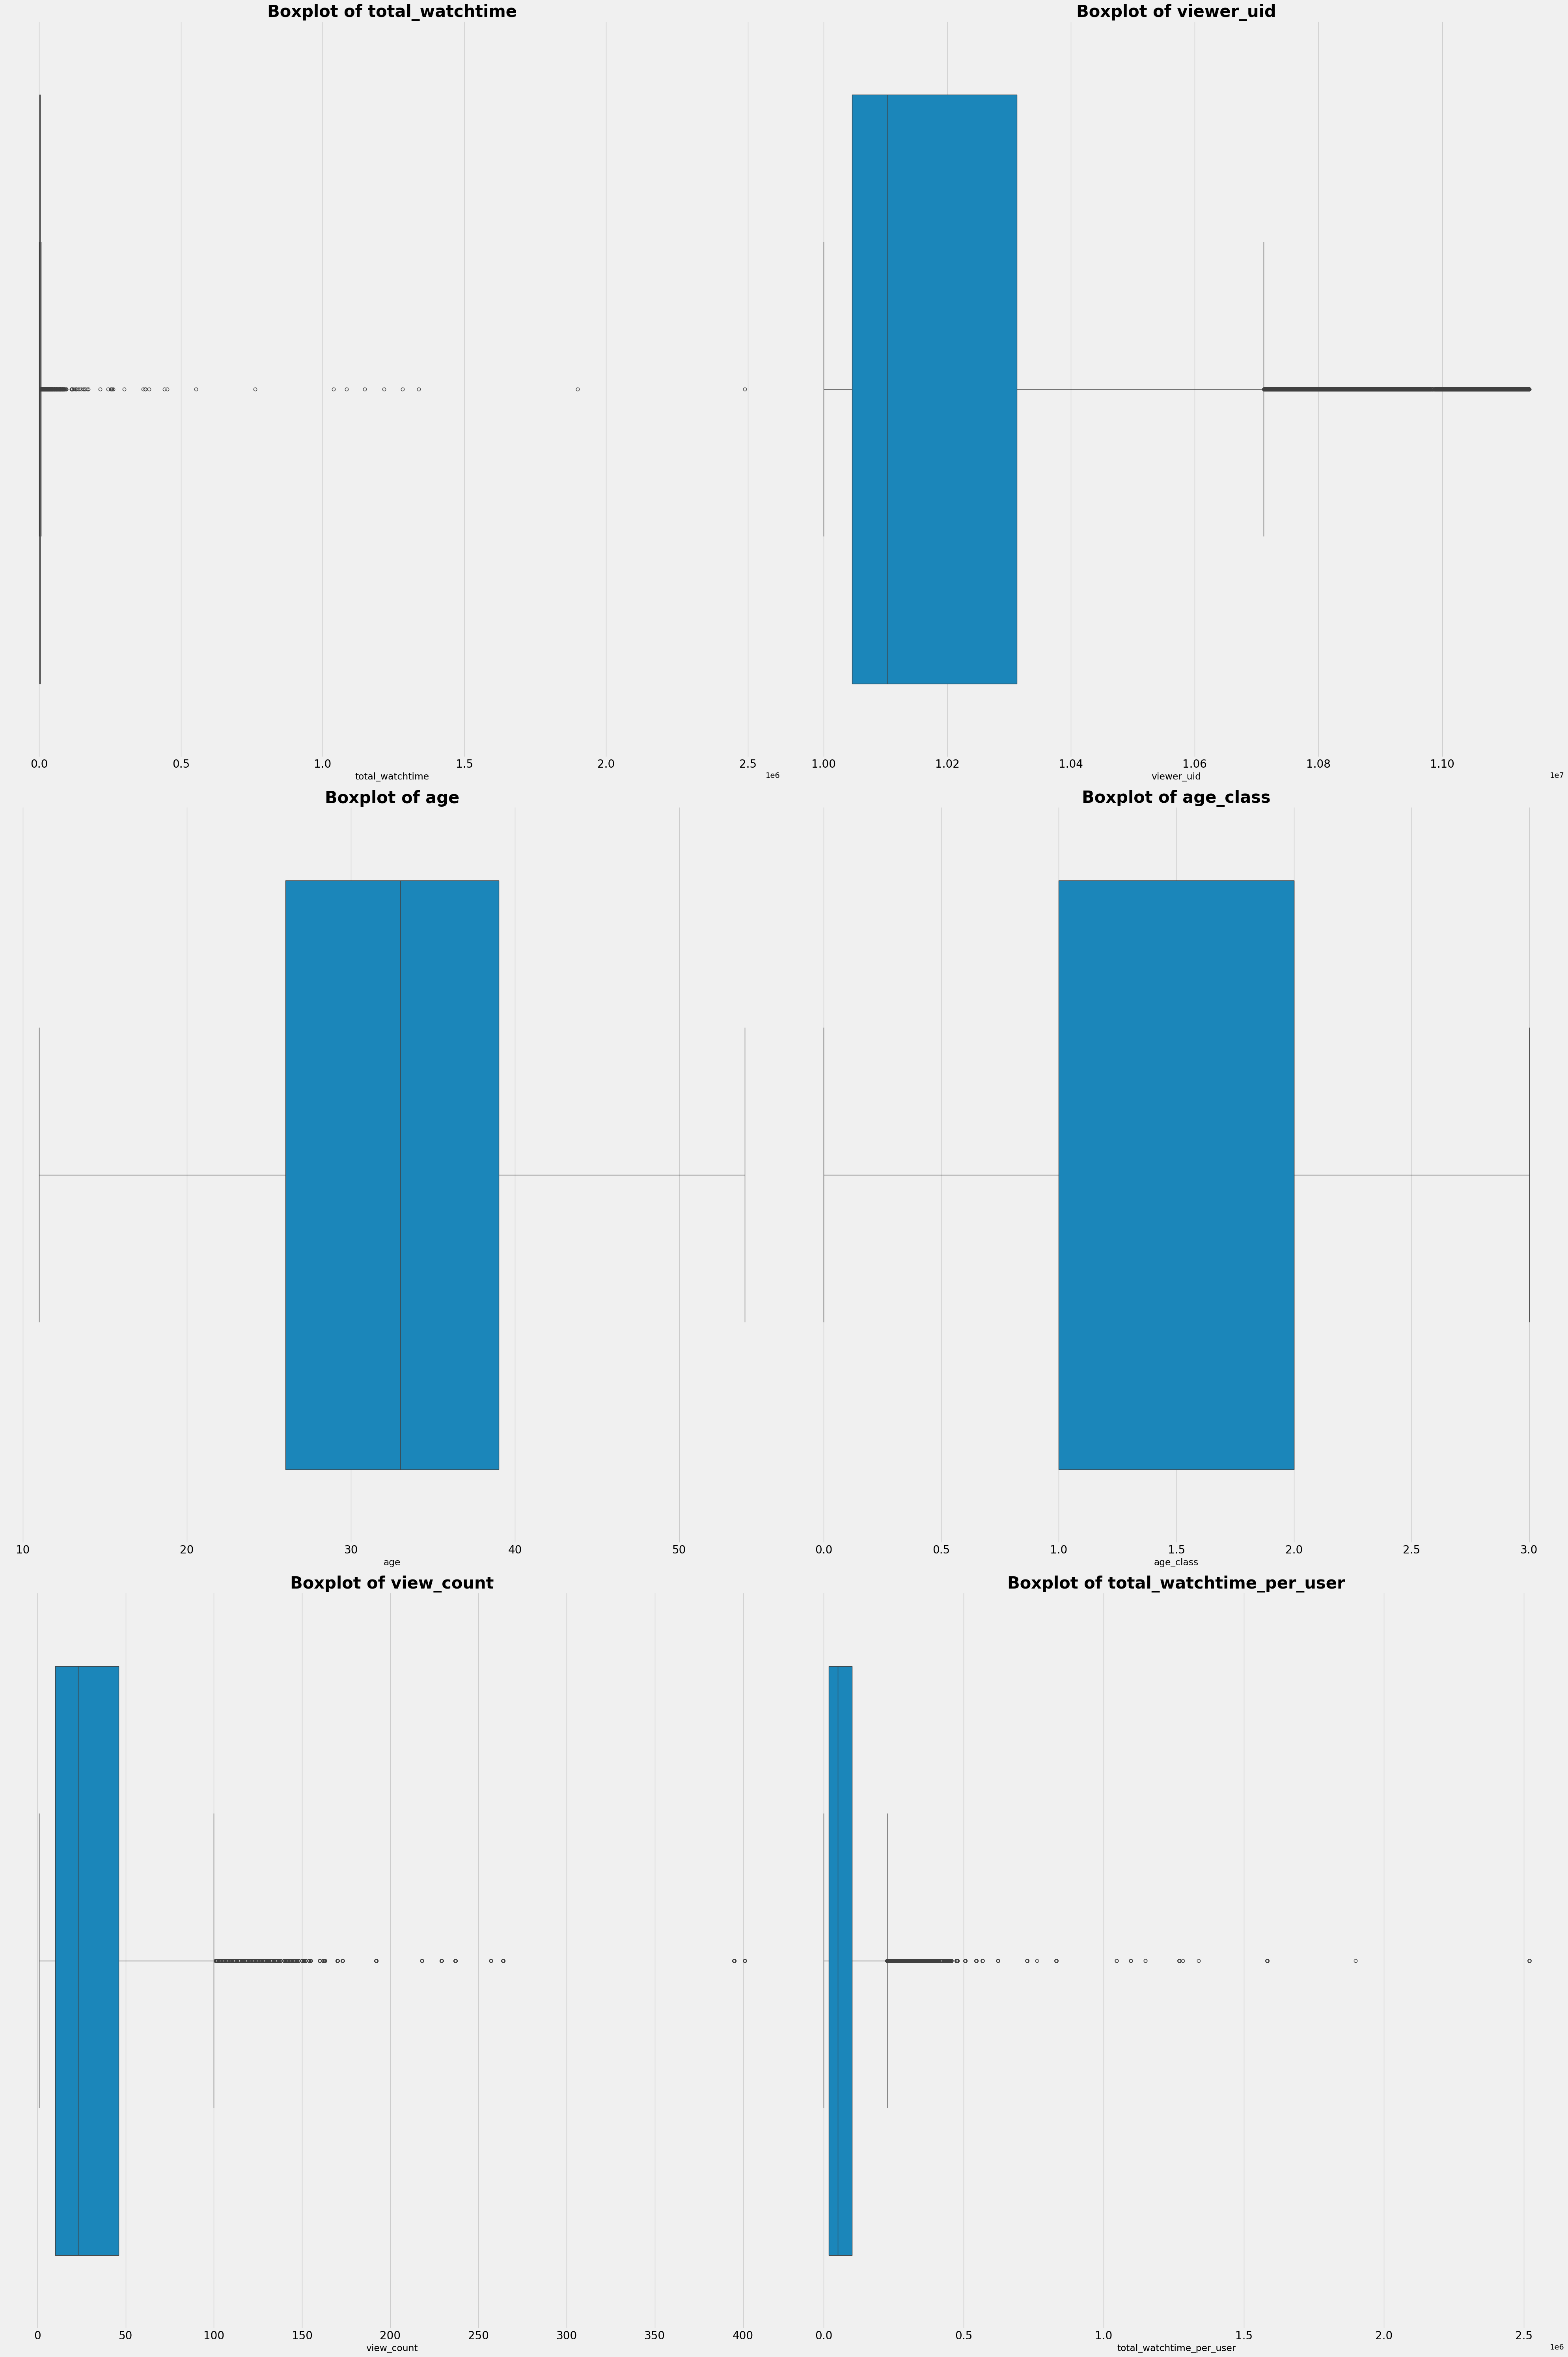

In [12]:
plot_boxplots(df)

In [13]:
# Так как на графиках четко видны пороги, отсекаем выбросы по порогам 
df=df[df.view_count <=150]
df=df[df.total_watchtime <=50000]
df=df[df.total_watchtime_per_user <=500000]

## Функция для кодирования перменных через LabelEncoder

In [18]:
def coder(df, cols):
    labelencoder = LabelEncoder()
    for col in cols:
        df[col] = labelencoder.fit_transform(df[col])
    return df
# Кодирование перменной "Пол"
coder(df,['sex'])

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,age,sex,age_class,view_count,total_watchtime_per_user
0,2024-06-01 06:40:58+03:00,Chelyabinsk,desktop,browser,Windows,Yandex Browser,1883,video_133074,10067243,20,0,0,43,122512
1,2024-06-01 19:33:24+03:00,Bashkortostan Republic,smartphone,mobile app,Android,Rutube,512,video_362960,10245341,40,0,2,67,170928
2,2024-06-01 21:30:43+03:00,St.-Petersburg,desktop,browser,Windows,Chrome,5647,video_96775,10894333,23,1,1,4,17300
3,2024-06-01 23:03:42+03:00,Moscow,smartphone,mobile app,Android,Rutube,1521,video_161610,10029092,41,1,3,10,13111
4,2024-06-01 22:48:09+03:00,Moscow,smartphone,mobile app,Android,Rutube,71,video_116245,10452976,38,0,2,33,45474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759611,2024-06-30 17:08:36+03:00,Moscow,smartphone,mobile app,Android,Rutube,4230,video_162776,10026914,32,0,2,35,82748
1759612,2024-06-30 01:20:16+03:00,Moscow,smartphone,browser,Android,Firefox Mobile,382,video_316157,10417567,48,1,3,6,2269
1759613,2024-06-30 22:37:04+03:00,St.-Petersburg,desktop,browser,Windows,Microsoft Edge,1342,video_83304,10009094,28,1,1,37,118699
1759614,2024-06-30 11:33:09+03:00,St.-Petersburg,smartphone,mobile app,Android,Rutube,801,video_132769,10574374,43,0,3,17,56413


# Для пола будет оцениваться именно метрика Accuracy

In [22]:
import pandas as pd
from catboost import CatBoostClassifier, Pool,metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

# Выбор признаков для обучения
X = df.drop(columns=['viewer_uid','sex', 'age', 'age_class','event_timestamp','ua_os'])  # Исключаем нецелевые столбцы 
y = df['sex']  # Целевая переменная - пол

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

# Обозначаем индексы категорильнах переменных
categorical_features_indices = np.where(X.dtypes == object)[0]

train_pool=Pool(X_train,y_train,cat_features=categorical_features_indices)
test_pool=Pool(X_test,y_test,cat_features=categorical_features_indices)

# Создание модели CatBoostClassifier
model_sex = CatBoostClassifier(
    iterations=3000, 
    depth=6,  # Уменьшите глубину, если наблюдается переобучение
    learning_rate=0.5,  # Попробуйте уменьшить скорость обучения
    l2_leaf_reg=3,  # Регуляризация
    cat_features=categorical_features_indices, 
    task_type='GPU',
    logging_level='Silent',
    custom_loss=[metrics.Accuracy()],
    early_stopping_rounds=100,  # Остановить обучение, если метрика не улучшается
    auto_class_weights = 'Balanced'  # Добавляем автоматическое определение весов классов
)

In [23]:
# Обучение модели
model_sex.fit(train_pool, 
          eval_set = test_pool,
          plot=True)

# Прогнозирование на тестовых данных
y_pred = model_sex.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Accuracy: 0.8637


## Метрики для модели опредления пола

In [24]:
# Отображение Accuracy
print(accuracy_score(y_test,y_pred))
# Отображение Classification report
print(classification_report(y_pred,y_test))
# Отображение Матрицы ошибок
print('Error matrix:','\n',confusion_matrix(y_pred,y_test))

0.8636521600419304
              precision    recall  f1-score   support

           0       0.86      0.91      0.89    202889
           1       0.87      0.79      0.83    148169

    accuracy                           0.86    351058
   macro avg       0.87      0.85      0.86    351058
weighted avg       0.86      0.86      0.86    351058

Error matrix: 
 [[185575  17314]
 [ 30552 117617]]


## Интерпретация модели для опредления пола пользователя с помщью алгоритма SHAP

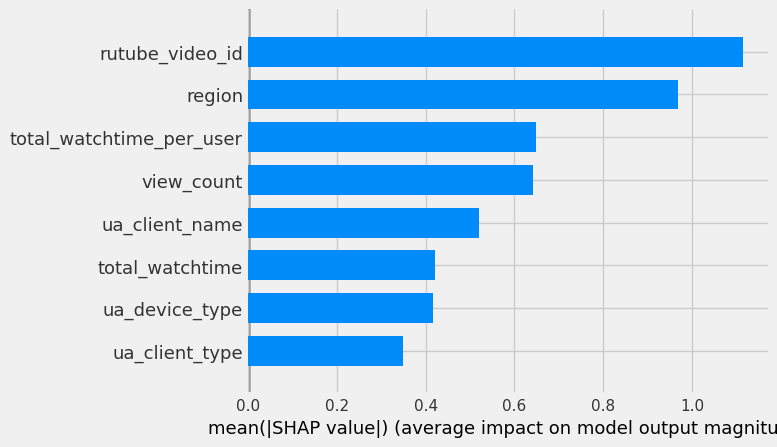

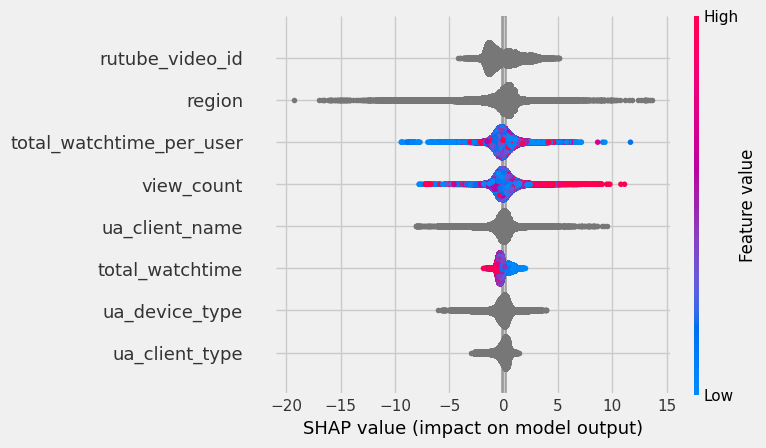

In [25]:
# Применение SHAP для анализа важности признаков
explainer = shap.TreeExplainer(model_sex)
shap_values = explainer.shap_values(X_test)

# Визуализация глобальной важности признаков
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Визуализация зависимости важности отдельных признаков
shap.summary_plot(shap_values, X_test)

## Расчет кросс валидации для модели для опредления пола

### Для данного датасета была использована StratifiedKFold, так как она сохраняет пропорцию классов целевой переменной в каждом фолде. Это полезно для задач классификации с несбалансированными классами

In [26]:
from catboost import cv, Pool

# Задаем параметры модели CatBoost
params = {
    'iterations': 3000,
    'depth': 6,
    'learning_rate': 0.5,
    'cat_features': categorical_features_indices,
    'l2_leaf_reg': 3,  # Регуляризация,
    'task_type': 'GPU',
    'eval_metric': 'Accuracy',  # Метрика для оценки
    'logging_level': 'Silent',  # Отключение логирования
    'early_stopping_rounds': 100,  # Остановится, если метрика не улучшится за 100 итераций
    'loss_function': 'Logloss'  # Указываем функцию потерь
}

# Выполняем кросс-валидацию с 5 фолдами и стратификацией
cv_data = cv(
    params=params,        # Параметры модели
    pool=train_pool,      # Данные для обучения
    fold_count=5,         # Количество фолдов
    stratified=True,      # Стратификация классов
    partition_random_seed=42,  # Сид для рандомизации
    shuffle=True,         # Перемешивание данных перед разделением
    verbose=False,        # Отключение подробных выводов
    plot=True,            # Включаем визуализацию
    as_pandas=True        # Возвращаем результат в формате DataFrame
)

# Вычисляем среднее значение метрики на всех фолдах
mean_accuracy = cv_data['test-Accuracy-mean'].max()

# Выводим среднее значение метрики
print(f'Среднее значение Accuracy на кросс-валидации: {mean_accuracy:.4f}')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Среднее значение Accuracy на кросс-валидации: 0.8367


## Сохранение модели

In [27]:
model_sex.save_model(r'C:\Users\Pasha\Desktop\хакатон\28.09.2208_sex_model.cbm')

# Для возраста будет оцениваться именно метрика F1 мера

In [28]:
import pandas as pd
from catboost import CatBoostClassifier,metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

# Выбор признаков для обучения
X = df.drop(columns=['sex', 'age', 'age_class','event_timestamp','ua_os'])  # Исключаем ненужные для обучения столбцы 
y = df['age_class']  # Целевая переменная - возрастная категория

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

# Обозначаем индексы категорильнах переменных
categorical_features_indices = np.where(X.dtypes == object)[0]

train_pool=Pool(X_train,y_train,cat_features=categorical_features_indices)
test_pool=Pool(X_test,y_test,cat_features=categorical_features_indices)

# Пример весов классов (1 — для классов с большим количеством примеров, 6 — для миноритарного класса)
# Создание модели CatBoostClassifier для мультиклассовой классификации
model_age = CatBoostClassifier(iterations=3000,
                           cat_features=categorical_features_indices, 
                           task_type='GPU',
                           logging_level='Silent',
                           depth=6,  # Уменьшите глубину, если наблюдается переобучение
                           learning_rate=0.5,  # Попробуйте уменьшить скорость обучения
                           l2_leaf_reg=3,  # Регуляризация
                           custom_loss=[metrics.Accuracy(),metrics.F1()],
                           auto_class_weights = 'Balanced'  # Добавляем автоматическое определение весов классов
                           )


In [29]:
model_age.fit(train_pool, 
          eval_set = test_pool,
          plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [30]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
# Прогнозирование на тестовых данных
y_pred = model_age.predict(X_test)
# Расчет F1-метрики с усреднением по классам
f1 = f1_score(y_test, y_pred, average='weighted')  # Можно выбрать 'micro', 'macro', или 'weighted'
print(f"F1 score: {f1}")
# Отчет по классификации
print(classification_report(y_test, y_pred))
# Матрица ошибок
print('Confusion matrix:', '\n', confusion_matrix(y_test, y_pred))

F1 score: 0.6801037582171927
              precision    recall  f1-score   support

           0       0.37      0.88      0.52     13259
           1       0.73      0.70      0.71    130279
           2       0.76      0.59      0.66    134440
           3       0.62      0.77      0.69     73080

    accuracy                           0.68    351058
   macro avg       0.62      0.73      0.64    351058
weighted avg       0.70      0.68      0.68    351058

Confusion matrix: 
 [[11707   665   361   526]
 [ 9545 90752 18323 11659]
 [ 7614 25510 78774 22542]
 [ 3115  6986  6735 56244]]


## Важность признаков основанная на Permutation importance

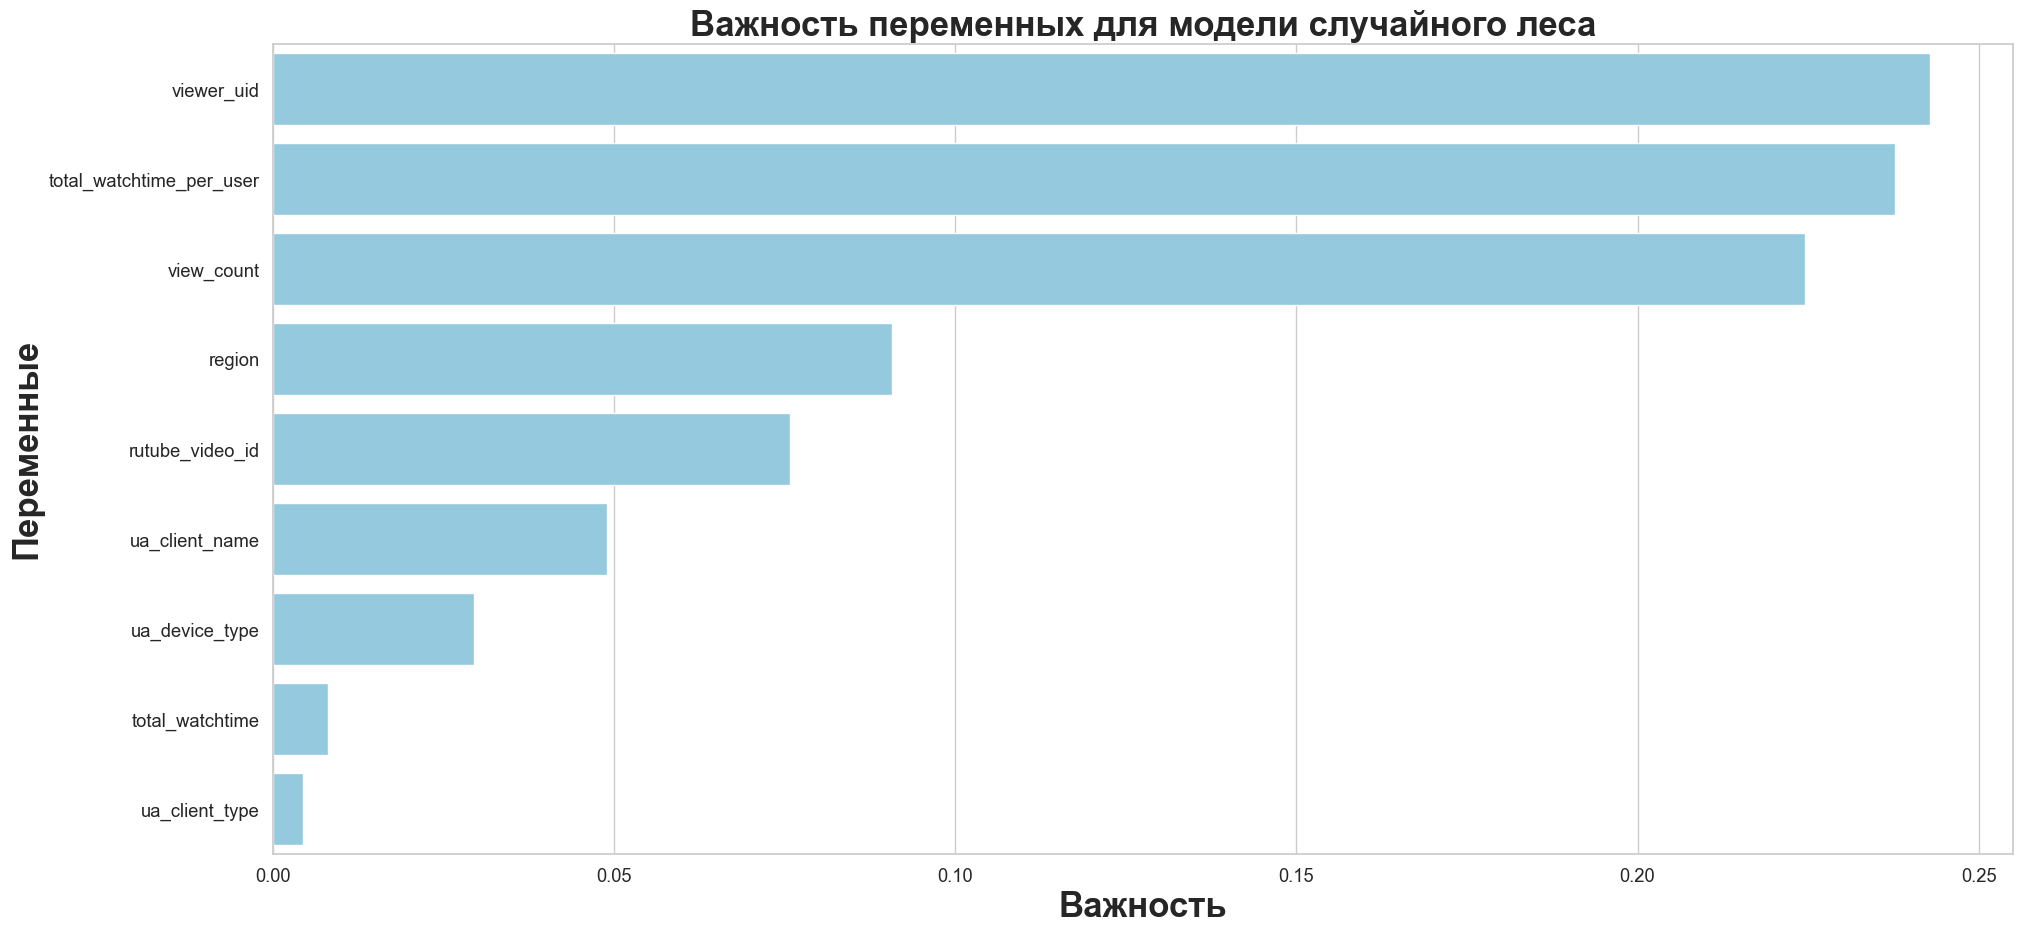

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Используем метод permutation_importance
r = permutation_importance(model_age, X_test, y_test, n_repeats=10, random_state=42)

# Добавляем результаты работы метода в DataFrame
perm_importance_df = pd.DataFrame({'Переменная': X_test.columns,
                                   'Важность': r.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Важность', ascending=False)

# Настраиваем и выводим график важности
sns.set(style="whitegrid", color_codes=True, font_scale=1.2)
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

# Построение графика
sns.barplot(x='Важность', y='Переменная', data=perm_importance_df, color='skyblue')

# Подписи
plt.xlabel('Важность', fontsize=25, weight='bold')
plt.ylabel('Переменные', fontsize=25, weight='bold')
plt.title('Важность переменных для модели случайного леса', fontsize=25, weight='bold')

plt.show()

## Расчет кросс валидации для модели для опредления возрастной группы

### Для данного датасета была использована StratifiedKFold, так как она сохраняет пропорцию классов целевой переменной в каждом фолде. Это полезно для задач классификации с несбалансированными классами

In [32]:
from catboost import cv, Pool

# Задаем параметры модели CatBoost для мультиклассовой классификации
params = {
    'iterations': 3000,
    'depth': 6,
    'learning_rate': 0.5,
    'cat_features': categorical_features_indices,
    'l2_leaf_reg': 3,  # Регуляризация
    'task_type': 'GPU',  # Если есть GPU, используйте его; если нет, замените на 'CPU'
    'eval_metric': 'TotalF1',  # F1 взвешенная
    'logging_level': 'Silent',  # Отключение логирования
    'early_stopping_rounds': 100,  # Остановить, если метрика не улучшится за 100 итераций
    'loss_function': 'MultiClass',  # Указываем функцию потерь для мультиклассовой классификации
    'custom_metric': ['Accuracy', 'TotalF1']  # Для оценки F1 и точности
}

# Выполняем кросс-валидацию с 5 фолдами и стратификацией
cv_data = cv(
    params=params,        # Параметры модели
    pool=train_pool,      # Данные для обучения
    fold_count=5,         # Количество фолдов
    stratified=True,      # Стратификация классов
    partition_random_seed=42,  # Сид для рандомизации
    shuffle=True,         # Перемешивание данных перед разделением
    verbose=False,        # Отключение подробных выводов
    plot=True,            # Включаем визуализацию
    as_pandas=True        # Возвращаем результат в формате DataFrame
)

# Вычисляем средние значения F1 и Accuracy на всех фолдах
mean_f1 = cv_data['test-TotalF1-mean'].max()
mean_accuracy = cv_data['test-Accuracy-mean'].max()

# Выводим средние значения метрик
print(f'Среднее значение F1 (взвешенное) на кросс-валидации: {mean_f1:.4f}')
print(f'Среднее значение Accuracy на кросс-валидации: {mean_accuracy:.4f}')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Среднее значение F1 (взвешенное) на кросс-валидации: 0.7192
Среднее значение Accuracy на кросс-валидации: 0.7210


## Сохранение модели

In [34]:
model_age.save_model(r'C:\Users\Pasha\Desktop\хакатон\28.09.2220_age_model.cbm')